In [81]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib
import os
import re
from tqdm import tqdm
from multiprocessing import Process, Manager, Pool
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools
import unidecode as un
import seaborn as sns

n_gram_alphabet_representation = "abcdefghijklmnopqrstuvwxyz"
ngram_count = 3

# N_Gram generation

In order to create n grams we went for the approach of unidecoding all of the letters in all languages in order to standardize
foreign letters to english alphabet. This might lose us some accuracy in the end since some letters such as bulgarian "я" and some other letter becoming "ia",
but we thought the combination of the the letter and how they get combined in each language should be enough, although some eastern european languages seem to have
suffered in accuracy possibly because of this reason.

In [82]:
def create_n_grams(sentances, n):
    n_gram_dic = {}
    for line in sentances:
        df = un.unidecode(line).lower()
        
        for x in df:
            if(x not in n_gram_alphabet_representation):
                df = df.replace(x, '')

        ngrams = [df[i:i+n] for i in range(len(df)-1)]
        for ngram in ngrams:
            if (n_gram_dic.get(ngram) is None):
                n_gram_dic[ngram] = 1
            else:
                n_gram_dic[ngram] += 1
    return n_gram_dic

In [83]:
def load_data(file_name):
    data = []
    path = os.getcwd() + f"\{file_name}"
    with open(file_name, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data

def load_multiple_data(dir_path, key, limit = None):
    data = []
    count = 0
    for file_name in os.listdir(dir_path):
        if limit is not None and count >= limit:
            break
        data.append((key, dir_path + "/" + file_name))
        count += 1
    return data

def get_subdirectories(base_path):
    subdirectories = []
    for root, dirs, files in os.walk(base_path):
        for dir in dirs:
            full_path = os.path.join(root, dir)
            subdirectories.append((dir, full_path))
    return subdirectories

def process_data_with_path(path_tuple):
    sentances_list = []
    labels_list = []
    n_grams_list = []
    unique_subdirs = {}
    for subdir, path in path_tuple:
        if(unique_subdirs.get(subdir) is None):
            unique_subdirs[subdir] = 1
            print("Loading data for: ", subdir)
        if os.path.isfile(path):
            sentances = load_data(path)
            n_grams = create_n_grams(sentances, ngram_count)
            labels_list.append(subdir)
            sentances_list += sentances
            n_grams_list.append(n_grams)
        else:
            for file in os.listdir(path):
                if "-sentences" in file:
                    full_file_path = os.path.join(path, file)
                    sentances = load_data(full_file_path)
                    n_grams = create_n_grams(sentances, ngram_count)
                    labels_list.append(subdir)
                    sentances_list += sentances
                    n_grams_list.append(n_grams)
    return labels_list, n_grams_list

def load_all_data(base_path):
    languages = get_subdirectories(base_path)

    labels_list, n_grams_list = process_data_with_path(languages)
    return labels_list, n_grams_list

# Generation of high dimensional vectors

This function follows closely to the paper and assignment hints. The one thing that they didn't mention in the paper is how to handle rolling
which we did by rolling based on index which would create unique vectors depending on letter and it's position in 
the n_gram.

# Answer to questions:

## 1. What will be the size of the n-gram input vector in conventional (local) representation?
This depends firstly on the size of the n-grams, as in if you are using bi-grams (2) or tri-grams (3) ect.
The other factor would be the size of the items you are working with. In the context of nlp it usually comes down
to either size of vocabulary in a language or the ammount of letters in that languages alphabet. So the size will be
I^n, where I is the item size (in our case 26 letters in the english alphabet) and n the n-gram size (in our case 3 since we are using tri-grams)

## 2. Identify difficulties of working with conventional representations of n-grams in the machine learning context.

High Dimensionality: As illustrated above, the size of the n-gram input vector can become extremely large, 
especially for large vocabularies and higher-order n-grams. This high dimensionality can lead to computational challenges and increased memory usage.

Sparsity: Most of the elements in the n-gram vectors are zero, especially for higher-order n-grams. 
This sparsity can be inefficient in terms of memory and computation, and it can negatively impact the performance of many machine learning algorithms.

Data Overfitting: Due to the large number of features (n-grams), there's a risk of overfitting, 
especially when the amount of training data is limited relative to the number of features.

Lack of Semantic Understanding: Conventional n-gram representations do not capture the semantics or meanings of words. 
They treat each n-gram as an independent feature without considering its context or relationship to other n-grams.

Computational Complexity: The process of generating and managing n-grams, especially for large datasets, 
can be computationally intensive. This includes both the generation of the n-grams themselves and the subsequent processing in machine learning models.
This was noticed during the lab where the loading and processing of the data was what took such a long time.

In [84]:
def generate_atomic_hd_vectors(dimensions):
    atomic_hd_vectors = {}
    for letter in n_gram_alphabet_representation:
        atomic_hd_vectors[letter] = np.random.choice([-1,1], dimensions)
    return atomic_hd_vectors

def h(list_of_sentances, atomic_hd_vectors, dimensions):
    list_of_h = []
    for s in list_of_sentances:
        h = np.zeros(dimensions)       
        for ngram in s.keys():
            n_i = np.random.choice([1], size = dimensions)
            s_i = s[ngram]
            j = 1
            for x in ngram:
                n_i = np.multiply(n_i, np.roll(atomic_hd_vectors[x], j))
                j +=1
            h += s_i * n_i
        h = h/np.linalg.norm(h)
        list_of_h.append(h)
    return(list_of_h)

# Predictions

Predictions are done by comparing the cosine similarity measure to all the training languages vectors and seeing which one is the highest

In [85]:
def predict(testing_h, training_h, training_labels):
    predictions = []
    for test in testing_h:
        cos = []
        for training in training_h:
            cosine = np.dot(test,training)/(np.linalg.norm(test)*np.linalg.norm(training))
            cos.append(cosine)
        maxIndex = np.argmax(cos)
        predictions.append(training_labels[maxIndex])
    return predictions

def accuracy_rating(predictions, test_labels):
    correct = 0
    for i in range(len(predictions)):
        if(predictions[i] == test_labels[i]):
            correct += 1
    return correct/len(predictions)

def run_experiments(dimensions, train_n_grams, train_labels, test_n_grams, test_labels):

    atomic_hd_vectors = generate_atomic_hd_vectors(dimensions)

    train_h = h(train_n_grams, atomic_hd_vectors, dimensions)
    test_h = h(test_n_grams, atomic_hd_vectors, dimensions)

    predicition_labels = predict(test_h, train_h, train_labels)
    print(f"################## Dimension count: {dimensions} ##################")
    print(predicition_labels)
    print(f"Accuracy: {accuracy_rating(predicition_labels, test_labels)}")
    print(f"F1 Score: {f1_score(predicition_labels, test_labels, average='weighted')}")
    print("Confusion Matrix:")
    confusion_matrix_string = confusion_matrix(predicition_labels, test_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_string, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

########################################### Training ###########################################
Loading data for:  bulgarian
Loading data for:  czech
Loading data for:  danish
Loading data for:  dutch
Loading data for:  english
Loading data for:  estonian
Loading data for:  finnish
Loading data for:  french
Loading data for:  german
Loading data for:  greek
Loading data for:  hungarian
Loading data for:  italian
Loading data for:  latvian
Loading data for:  lithuanian
Loading data for:  polish
Loading data for:  portuguese
Loading data for:  romanian
Loading data for:  slovak
Loading data for:  slovene
Loading data for:  spanish
Loading data for:  swedish
########################################### Testing ###########################################
Loading data for:  finnish
Loading data for:  german
Loading data for:  english
Loading data for:  french
Loading data for:  italian
Loading data for:  spanish
Loading data for:  swedish
Loading data for:  dutch
Loading data for:  portugue

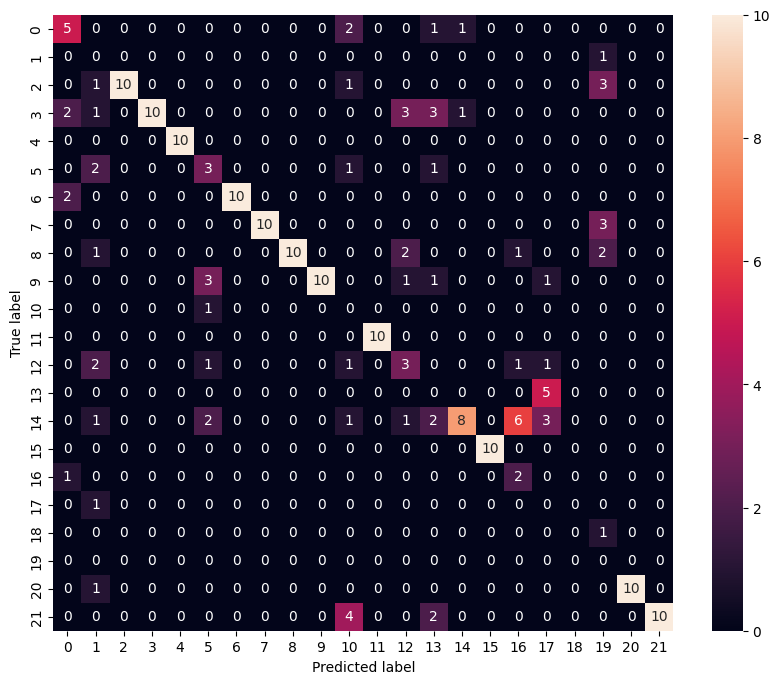

################## Dimension count: 1000 ##################
['finnish', 'finnish', 'finnish', 'finnish', 'finnish', 'finnish', 'finnish', 'finnish', 'finnish', 'finnish', 'german', 'german', 'german', 'german', 'german', 'german', 'german', 'german', 'german', 'german', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'french', 'french', 'french', 'french', 'french', 'french', 'french', 'french', 'french', 'french', 'italian', 'italian', 'italian', 'italian', 'italian', 'italian', 'italian', 'italian', 'italian', 'italian', 'spanish', 'spanish', 'spanish', 'spanish', 'spanish', 'spanish', 'spanish', 'spanish', 'spanish', 'spanish', 'swedish', 'swedish', 'swedish', 'swedish', 'swedish', 'swedish', 'swedish', 'swedish', 'swedish', 'swedish', 'dutch', 'dutch', 'dutch', 'dutch', 'dutch', 'dutch', 'dutch', 'dutch', 'dutch', 'dutch', 'portuguese', 'portuguese', 'portuguese', 'portuguese', 'portuguese', 'portuguese', 'portuguese', '

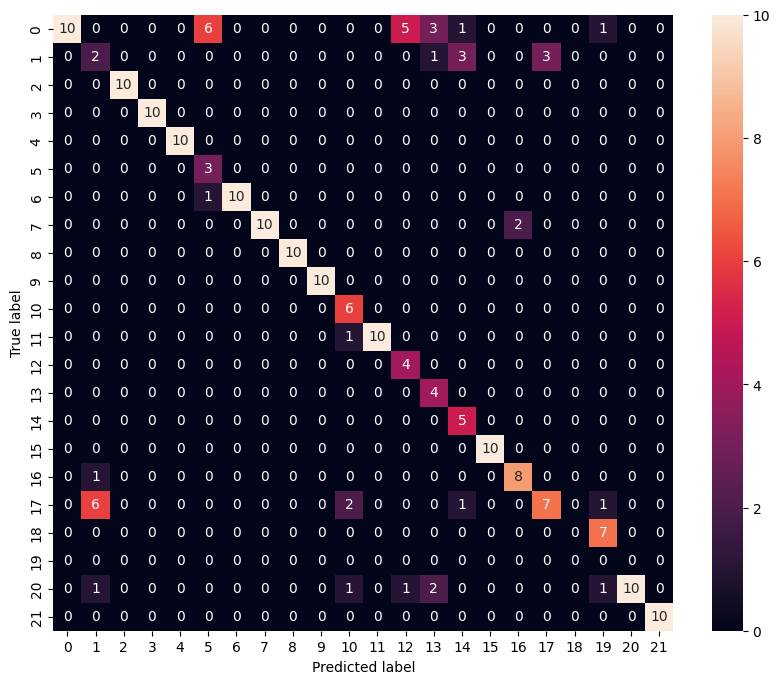

In [86]:
print("########################################### Training ###########################################")
train_labels, train_n_grams = load_all_data('datasets/training_data/')

test_directories = [
            ('finnish','datasets/europarl/txt/fi'), 
            ('german','datasets/europarl/txt/de'), ('english','datasets/europarl/txt/en'), 
            ('french','datasets/europarl/txt/fr'), ('italian','datasets/europarl/txt/it'), ('spanish','datasets/europarl/txt/es'),
            ('swedish','datasets/europarl/txt/sv'), ('dutch','datasets/europarl/txt/nl'), ('portuguese','datasets/europarl/txt/pt'),
            ('czech','datasets/europarl/txt/cs'), ('polish','datasets/europarl/txt/pl'), ('slovak','datasets/europarl/txt/sk'),
            ('hungarian','datasets/europarl/txt/hu'), ('romanian','datasets/europarl/txt/ro'), ('bulgarian','datasets/europarl/txt/bg'),
            ('danish','datasets/europarl/txt/da'), ('estonian','datasets/europarl/txt/et'), ('greek','datasets/europarl/txt/el'),
            ('latvian','datasets/europarl/txt/lv'), ('lithuanian','datasets/europarl/txt/lt'), ('slovenian','datasets/europarl/txt/sl')
            ]

print("########################################### Testing ###########################################")

test_paths = []

for path in test_directories:
    test_paths += load_multiple_data(path[1], path[0], 10)

test_labels, test_n_grams = process_data_with_path(test_paths)

run_experiments(100, train_n_grams, train_labels, test_n_grams, test_labels)
run_experiments(1000, train_n_grams, train_labels, test_n_grams, test_labels)



